#Imports and Helper Functions

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt

from numpy.linalg import eig, norm
# made an rsme function.
from sklearn.metrics import mean_squared_error

In [ ]:
def standardize(X):
  return X / norm(X)

In [ ]:
def rsme(y_true, y_pred):
  return np.sqrt(np.mean((y_pred - y_true) ** 2))

In [ ]:
# Functions made by using the listed formulas from this source: 
# https://en.wikipedia.org/wiki/Confusion_matrix

# recall
def true_positive_rate(TP, FN):
    return (TP / (TP + FN))
# selectivity
def true_negative_rate(TN, FP):
    return (TN / (TN + FP))
# precision
def positive_predictive_value(TP, FP):
    return (TP / (TP + FP))
def negative_predictive_value(TN, FN):
    return (TN / (TN + FN))
# miss rate
def false_negative_rate(FN, TP):
    return (FN / (FN + TP))
# fall-out
def false_positive_rate(FP, TN):
    return (FP / (FP + TN))

def false_discovery_rate(FP, TP):
    return (FP / (FP + TP))

def false_omission_rate(FN, TN):
    return (FN / (FN + TN))

def prevalence_threshold(TPR, TNR):
    return (np.sqrt(TPR(-TNR + 1) + TNR - 1)) / (TPR + TNR - 1)

def threat_score(TP, FN, FP):
    return TP / (TP + FN + FP)

def accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + TN + FP + FN)

# added to complete question 3
def generalization_error(ACC):
    return abs(ACC - 1)

def balanced_accuracy(TPR, TNR):
    return (TPR + TNR) / 2

def f1_score(PPV, TPR):
    return 2 * ((PPV * TPR) / (PPV + TPR))

def matthews_correlation_coefficient(TP, TN, FP, FN):
    return (TP * TN - FP * FN) / np.sqrt((TP + FP)(TP + FN)(TN + FP)(TN + FN))

def fowlkes_mallows_index(PPV, TPR):
    return np.sqrt(PPV * TPR)

def bookmaker_informedness(TPR, TNR):
    return TPR + TNR - 1

def markedness(PPV, NPV):
    return PPV + NPV -1

In [ ]:
def confusion_matrix_binary(actual, prediction):
  pred_u = np.unique(prediction)
  act_u = np.unique(actual)
  df = pd.crosstab(actual, prediction)
  if -1.0  not in pred_u:
    df['-1.0'] = [0,0] 
  if 1.0  not in pred_u:
    df['1.0'] = [0,0] 
  return df
def confusion_matrix_binary_values(cm):
    TN = cm.iloc[0,0]
    try:
      FP = cm.iloc[0,1]
    except IndexError:
      FP = 0
    FN = cm.iloc[1,0]
    try:
      TP = cm.iloc[1,1]
    except IndexError:
      TP = 0
    # returns TN, FP, FN, TP
    return TN, FP, FN, TP

In [ ]:
def confused_accuracy(y_true, y_pred):
  cm = confusion_matrix_binary(y_true, y_pred)
  TN, FP, FN, TP = confusion_matrix_binary_values(cm)
  acc = accuracy(TP, TN, FP, FN)
  return acc

In [ ]:
def partition(f_matrix, t_vector, T):
    if (len(f_matrix) != len(t_vector)):
        raise Exception('Your feature matrix is not of the same length as your testing vector.')
    split_value = int(len(f_matrix)*T)
    test_matrix = f_matrix[:split_value]
    test_vector = t_vector[:split_value]
    train_matrix = f_matrix[split_value:]
    train_vector = t_vector[split_value:]
    return train_matrix, train_vector, test_matrix, test_vector

# Part A: Linear Support Vector Machine (SVM)

## 1. Linear_SVC

This model class performs binary classification. The model implements the batch Gradient Descent (GD) algorithm.

###a.) Lost/Cost function of the Linear SVM

Initialize the weight vector $\vec{w}$ with small random numbers and the scalar intercept/bias $b$ with zero.
$\vec{t}$ $\vec{x}$

i.) Find the Support Vector Matrix $\vec{X}_{sv}$ and Label Vector $\vec{t}_{sv}$

$$\vec{t}.(\vec{X}.\vec{w}+b) < 1$$

ii.) Compute the cost J:

$$J = \frac{1}{2}\vec{w}^T\vec{w}+C\Big[\sum(1-\vec{X}_{sv}.\vec{w})-b\sum\vec{t}_{sv}\Big]$$

iii.) Compute the derivative of the cost function with respect to the weight vector $\vec{w}$ and the intercept/bias $b$:

$$\nabla_\vec{w}J = \vec{w} - C\sum\vec{X}_{sv}$$

$$\nabla_bJ= -C\sum\vec{t}_{sv}$$

iv.) Update both $\vec{w}$ and $b$.

$$ \vec{w} := \vec{w} - \eta.\nabla_\vec{w}J $$

$$ b := b - \eta.\nabla_bJ $$


In [ ]:
class Linear_SVC:
  def __init__ (self, C=1, max_iter=100, tol=None, 
                learning_rate='constant', learning_rate_init=0.001,
                t_0=1, t_1=1000, early_stopping=False,
                validation_fraction=0.1, **kwargs):
    # C : float - 
    #  It provides the regularization/penalty coefficient. 
    self.C = C

    # max_iter : int - 
    #  Maximum number of iterations.
    #  The GD algorithm iterates until convergence (determined by ‘tol’) or this
    #  number of iterations.
    self.max_iter = max_iter

    # tol: float - Tolerance for the optimization. 
    self.tol = tol

    # learning_rate : string (default 'constant') - 
    #  It allows to specify the technique to set the learning rate:
    #    - 'constant' : constant learning rate given by 'learning_rate_init'.
    #    - 'adaptive' : gradually decreases the learning rate based on a schedule.
    self.learning_rate = learning_rate

    # learning_rate : double - 
    #  The initial learning rate value if learning_rate is set to ‘constant’. 
    #  It controls the step-size in updating the weights.
    #  It has no effect if the ‘learning_rate’ is ‘adaptive’
    self.learning_rate_init = learning_rate_init


    self.t_0 = t_0
    self.t_1 = t_1

    # early_stopping : boolean (default=False) -
    #  Whether to use early stopping to terminate training when validation score
    #  is not improving.
    #  - True : it will automatically set aside a fraction of training data as 
    #           validation and terminate training when validation score is not 
    #           improving.
    self.early_stopping = early_stopping

    # validation_fraction : float (default=0.1) -
    #  The proportion of training data to set aside as validation set for early
    #  stopping.
    #  Only used if early_stopping is True.
    self.validation_fraction = validation_fraction

  # ----------------------------------------------------------------------------
  # fit:
  #   Implement the batch GD algorithm.
  #   The weight vector and the intercept/bias should be denoted by w and b.
  #   Store the cost values for each iteration so that later you can use it to 
  #   create a learning curve
  #
  #   Should display the total number of iterations using a print statement.
  # ---------------------------------------------------------------------------
  # Arguments:
  #
  #   X⃗ : ndarray -
  #     A numpy array with rows representing data samples and columns 
  #     representing features.
  #
  #   y : ndarray - 
  #     A 1D numpy array with labels corresponding to each row of the feature
  #     matrix X.
  #
  # 
  def fit(self, X⃗, y):
    
    # Initialize the weight vector w⃗ with small random numbers
    w⃗ = np.random.random(size=(X⃗.shape[1], 1))

    # Initialize the scalar intercept/bias b with zero
    b = 0

    C = self.C

    self.iterations = 1

    if (self.learning_rate == 'adaptive'):
      η = self.adapt(self.t_0, self.t_1, self.iterations)
    else:
      η = self.learning_rate_init

    t⃗ = y

    # setting cost to 100%
    J_old = 1.0

    if self.early_stopping:
      train_matrix, train_vector, test_matrix, test_vector = partition(X⃗, y, self.validation_fraction)
      validation_error_prev = 1.0

    for i in range(self.max_iter):
      self.iterations += 1


      # i.) Find the Support Vector Matrix  X⃗_sv  and Label Vector t⃗_sv

      # If w⃗.T @ x⃗ + b ≥ 1; then class = positive (+1), otherwise negative (-1).
      # This is done via vector format 
      # t⃗ .(X⃗ .w⃗ +b) < 1
      idx = ((t⃗ * (X⃗ @ w⃗ + b)) < 1).ravel()
      X⃗_sv = X⃗[idx]
      t⃗_sv = t⃗[idx]

      # ii.) Compute the cost J
      J = 0.5 * (w⃗.T @ w⃗) + C * (np.sum(1 - X⃗_sv @ w⃗) - b * np.sum(t⃗_sv))
    
      # iii.) Compute the derivative of the cost function with respect to the 
      #       weight vector w⃗ and the intercept/bias b
      # _w⃗J == ∇w⃗J
      _w⃗J = w⃗ - C * np.sum(X⃗_sv)
      # _bJ == ∇bJ
      _bJ = - C * np.sum(t⃗_sv)

      # iv.) Update both w⃗ and b.
      w⃗_old = w⃗
      w⃗ = w⃗ - η * _w⃗J
      b = b - η * _bJ

      # exit if tolerance is met
      if (self.tol != None):
         if (abs(J_old - J) < tol):
           break
         else:
           J_old = J

      # adaptive learning rate
      if (self.learning_rate == 'adaptive'):
        η = self.adapt(self.t_0, self.t_1, self.iterations)
      
      self.intercept_ = b
      self.coef_ = w⃗
      #print(len(X⃗_sv))
      self.support_vectors_ = X⃗_sv

      if self.early_stopping:
        validation_predictions = self.predict(test_matrix)
        val_cm = confusion_matrix_binary(test_vector.ravel(), 
                                         validation_predictions.ravel())
        TN, FP, FN, TP = confusion_matrix_binary_values(val_cm)
        acc = accuracy(TP, TN, FP, FN)
        validation_error = generalization_error(acc)
        if (validation_error_prev > validation_error):
          validation_error_prev = validation_error
        else:
          break

    print("Total iterations: {}".format(self.iterations - 1))


  # predict:
  #   Uses self.coef_ and self.intercept_ to make predictions.
  def predict(self, X):
    return np.sign(X @ self.coef_ + self.intercept_)
    pass
  
  # Write a function that would be used if learning_rate is set to ‘adaptive’.
  # When ‘adaptive’ is used, the ‘learning_rate_init’ parameter has no effect as
  #  the learning rate varies by a learning rate schedule function. 
  # It uses the ‘t_0’ and ‘t_1’ parameters.

  # learning_rate_adaptive = t_0 / ('iteration' + t_1)
  # where t_0 and t_1 are two constants that you need to determine empirically.
  # Choose constant t_0 and t_1 such that initially the learning rate is large
  #  enough.
  def adapt(self, t_0, t_1, iteration):
    learning_rate_adaptive = t_0 / (iteration + t_1)
    return learning_rate_adaptive

## Binary Classification using Linear_SVC

### 2. Read the Iris data using the ***sklearn.datasets.load_iris*** method. 
Create the data matrix **X** by using two features: 
- *petal length*
- *petal width* 

Recode the binary target such that Iris-Virginica samples are 1, and other samples are 0.

In [ ]:
iris = load_iris()
df = pd.DataFrame(data=iris.data)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       150 non-null    float64
 1   1       150 non-null    float64
 2   2       150 non-null    float64
 3   3       150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
# petal_width and petal_length are the last two columns in the iris data set.
X = np.delete(iris.data, [0,1], axis=1)

# Iris-Virginica == 2, if true = 1 if false = 0
y = np.reshape(np.where(iris.target == 2, 1, -1), (-1,1))

# shuffle data for randomness
dataset = np.append(X, y, axis=1)
np.random.shuffle(dataset)
shuffled_dataset = np.array_split(dataset, 2, axis=1)

X = shuffled_dataset[0]
s = StandardScaler()
X = s.fit_transform(X)
y = shuffled_dataset[1]

###3. Partition the data into train and test set (80% - 20%).
Use the **partition** function from your previous assignment.

In [ ]:
train_matrix, train_vector, test_matrix, test_vector = partition(X, y, .2)

###4. Model selection via Hyper-parameter tuning:
Use the **kFold** function from previous assignment to find the optimal values for the following hyperparameters.
- C
- learning_rate
- learning_rate_init (when 'constant' learning_rate is used)
- max_iter
- tol

In [ ]:
def kFold(data, labels, model, model_args, folds):
    data_size = len(data)
    s_partition_size = 1 / folds
    segment_indexes = [ [int(np.floor(s_partition_size * i * data_size)), 
                         int(np.floor(s_partition_size * (i + 1) * data_size) - 1)] for i in range(folds) ]
    ret = {}
    for p in range(folds):
        key = str('s%d' % p)
        # takes the current segment as training data
        test_data = data[segment_indexes[p][0]:segment_indexes[p][1]]
        test_labels = labels[segment_indexes[p][0]:segment_indexes[p][1]]
        
        # creates copies of the data and labels with the testing data segment removed.
        train_data = np.delete(data, np.s_[segment_indexes[p][0]:segment_indexes[p][1]], 0)
        train_labels = np.delete(labels, np.s_[segment_indexes[p][0]:segment_indexes[p][1]], 0)
        
        model.fit(train_data, train_labels, **model_args)
        prediction_labels = model.predict(test_data)

        # train and test prediction ***
        train_prediction_labels = model.predict(train_data)
        test_prediction_labels = model.predict(test_data)
        
        # error_function is a decorator for the functioon being used 
        # so long as you pass a function without the parenthesis 

        # train_score and test_score ***. |  rsme(y_true, y_pred)
        train_score = rsme(train_labels.ravel(), train_prediction_labels.ravel())
        validation_score = rsme(test_labels.ravel(), test_prediction_labels.ravel())

        cm = confusion_matrix_binary(train_labels.ravel(), train_prediction_labels.ravel())
        TN, FP, FN, TP = confusion_matrix_binary_values(cm)
        train_acc = accuracy(TP, TN, FP, FN)
        

        cm = confusion_matrix_binary(test_labels.ravel(), test_prediction_labels.ravel())
        TN, FP, FN, TP = confusion_matrix_binary_values(cm)
        val_acc = accuracy(TP, TN, FP, FN)

        ret[key] = {'test_labels' : test_labels, 
                    'prediction_labels' : prediction_labels, 
                    'train_score' : train_acc, 
                    'validation_score' : val_acc
                    }
                    
            
    # adding in a tust model to weed out bad results from poorly constructed confusion matrix.
    avg_training_score_sum = 0
    avg_validation_score_sum = 0
    for fold in ret:
        avg_training_score_sum += ret[fold]['train_score']
        avg_validation_score_sum += ret[fold]['validation_score']

    avg_training_score = avg_training_score_sum / len(ret)
    avg_validation_score = avg_validation_score_sum / len(ret)

    ret['train_score'] = avg_training_score
    ret['validation_score'] = avg_validation_score
    ret['model'] = { 'C' : model.C,
                     'learning_rate' : model.learning_rate,
                     'learning_rate_init' : model.learning_rate_init,
                     'max_iter' : model.max_iter,
                     'tol' : model.tol,
                     'iterations' : model.iterations -1}
    # print('Training Score: ', avg_training_score)
    # print('Validation Score: ', avg_validation_score)

    return ret

In [ ]:
results_list = []
for C in [0.1, 1, 10]:
  for learning_rate in ['constant', 'adaptive']:
    for learning_rate_init in [0.01, 0.001, 0.0001]:
      for max_iter in [10, 100, 1000]:
        for tol in [None, 0.1, 0.001]:
          #print('C: ', C)
          #print('learning_rate: ', learning_rate)
          #print('learning_rate_init: ', learning_rate_init)
          #print('max_iter: ', max_iter)
          #print('tol: ', tol)
          kfolds = kFold(data=X, 
                        labels=y,
                        model=Linear_SVC(C, 
                                         max_iter, 
                                         tol, 
                                         learning_rate, 
                                         learning_rate_init),
                        model_args={},
                        folds=5)
          results_list.append(kfolds)

In [ ]:
res_val_scores = [results_list[i]['validation_score'] for i in range(len(results_list))]

In [ ]:
res_val_scores = np.array(res_val_scores)
best_idx = np.where(res_val_scores == np.amax(res_val_scores))[0][0]
best_model = results_list[best_idx]['model']

In [ ]:
print(best_model)

{'C': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, 'tol': 0.1, 'iterations': 1000}


##6. Plot the learning curve

In [ ]:
def learning_curve(X, 
                   Y, 
                   C, 
                   max_iter,
                   tol,
                   learning_rate,
                   learning_rate_init,
                   train_size=1, 
                   **kwargs):
  
  #Get training set size
  if np.issubdtype(train_size.dtype, np.floating):
    if np.min(train_size >= 0) and np.max(train_size <= 1):
      train_size = np.unique(train_size*X.shape[0])
      train_size = np.ceil(train_size)
      train_size = np.int32(train_size)
  
  results = []
  for train_set in train_size:
    data = X[0:train_set]
    labels = np.asarray([Y[0:train_set]]).T
    kfolds = kFold(data=X, 
                    labels=Y,
                    model=Linear_SVC(C, 
                                     max_iter, 
                                     tol, 
                                     learning_rate,
                                     learning_rate_init),
                    model_args={},
                    folds=5)
    results.append(kfolds)
    
  return results, train_size

Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000
Total iterations: 1000


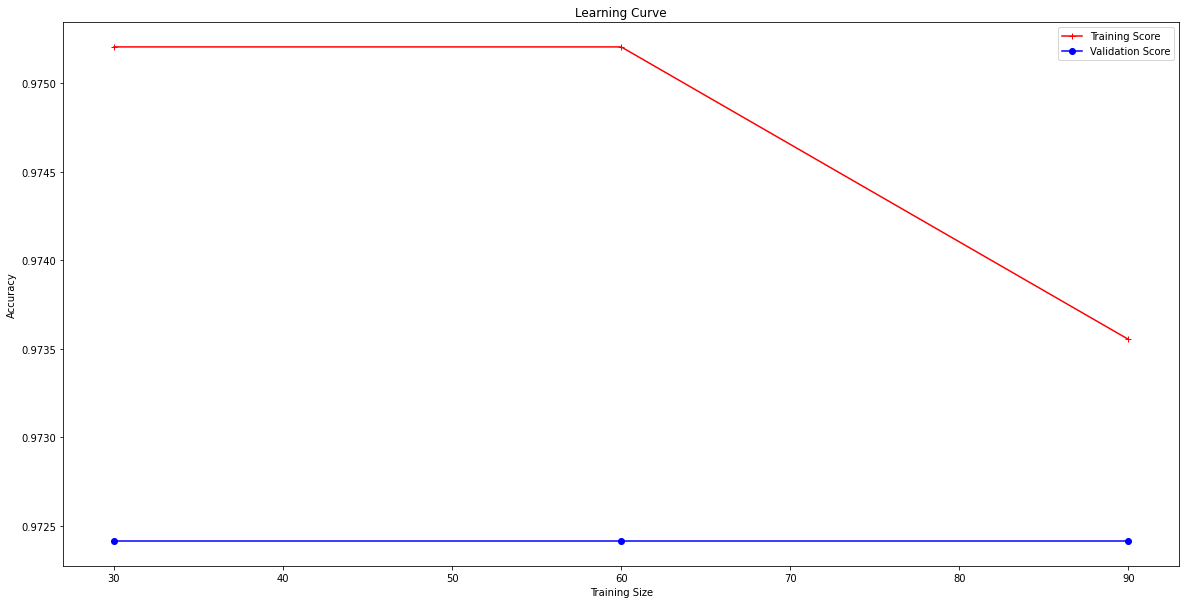

In [ ]:
results, train_sizes = learning_curve(
    X=X, 
    Y=y,
    C=best_model['C'], 
    max_iter=best_model['max_iter'],
    tol=best_model['tol'],
    learning_rate=best_model['learning_rate'],
    learning_rate_init=best_model['learning_rate_init'],
    train_size=np.linspace(0.2, 0.6,num=3))

train_scores = [results[i]['train_score'] for i in range(len(results))]
val_scores = [results[i]['validation_score'] for i in range(len(results))]

fig = plt.figure(figsize=(20,10))
plt.plot(train_sizes, train_scores, 'r-+', label='Training Score')
plt.plot(train_sizes, val_scores, 'b-o', label='Validation Score')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
#plt.ylim(0.95, 1.0)
plt.legend()

##7. Plot the decision boundary and show the support vectors using the “decision_boundary_support_vectors” function given in: https://github.com/rhasanbd/Support-Vector-Machine-Classifier-Beginners-Survival-Kit/blob/master/Support%20Vector%20Machine-1-Linearly%20Separable%20Data.ipynb

##Note that if your test accuracy is less than 95%you will lose 10% of the total obtained points. If your test accuracy is less than 90%you will lose 30% of the total obtained points.

In [ ]:
svm_clf =Linear_SVC(C=best_model['C'], max_iter=best_model['max_iter'], 
           tol=best_model['tol'], learning_rate=best_model['learning_rate'], 
           learning_rate_init=best_model['learning_rate_init'])

#svm_clf = Linear_SVC()

best_test_size = abs(np.where(val_scores == np.amax(val_scores))[0][0] - 1)

train_matrix, train_vector, test_matrix, test_vector = partition(X, y, .2)

svm_clf.fit(train_matrix, train_vector)


Total iterations: 1000


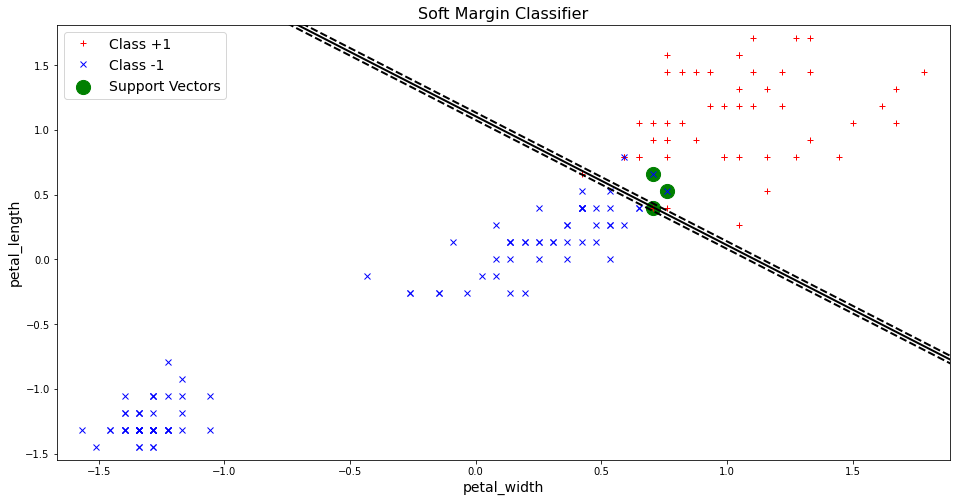

In [ ]:
def decision_boundary_support_vectors(svm_clf, X):
  xmin, xmax = X.min() - 1 , X.max() + 1
    
  w = svm_clf.coef_
  b = svm_clf.intercept_
  #print(w)
  #print(b)
  #print(svm_clf.support_vectors_)
  # At the decision boundary, w1*x1 + w2*x2 + b = 0
  # => x2 = -(b + w1* x1)/w1
  x1 = np.linspace(xmin, xmax, 2)
  
  decision_boundary = -(b + w[0] * x1) / w[1]
  shifting_factor_for_margin = 1/w[1]
  upper_margin = decision_boundary + shifting_factor_for_margin
  lower_margin = decision_boundary - shifting_factor_for_margin
  svs = svm_clf.support_vectors_
  plt.scatter(svs[:, 0], svs[:, 1], s=200, facecolors='g', label="Support Vectors")
  plt.plot(x1, decision_boundary, "k-", linewidth=2)
  plt.plot(x1, upper_margin, "k--", linewidth=2)
  plt.plot(x1, lower_margin, "k--", linewidth=2)


plt.figure(figsize=(16,8))
positive_class = X[y.ravel() == 1]
negative_class = X[y.ravel() == -1]
plt.plot(positive_class[:, 0], positive_class[:, 1], "r+", label="Class +1")
plt.plot(negative_class[:, 0], negative_class[:, 1], "bx", label="Class -1")


decision_boundary_support_vectors(svm_clf, X)



plt.xlabel("petal_width", fontsize=14)
plt.ylabel("petal_length", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("Soft Margin Classifier", fontsize=16)
plt.axis([np.amin(X[:, 0])-0.1, np.amax(X[:, 0])+0.1, 
          np.amin(X[:, 1])-0.1, np.amax(X[:, 1])+0.1])
#plt.xticks(())
#plt.yticks(())
#plt.
plt.show()

##8. [Extra Credit for 478 and Mandatory for 878]   
##Implement early stopping in the “fit” method of the Linear_SVC model. You will have to use the following two parameters of the model: early_stopping and validation_fraction. Also note that when training the model using early stopping it should generate an early stopping curve.

In [ ]:
svm_clf_2 = Linear_SVC(C=best_model['C'], max_iter=best_model['max_iter'], 
           tol=best_model['tol'], learning_rate=best_model['learning_rate'], 
           learning_rate_init=best_model['learning_rate_init'],
           t_0=1, t_1=10,
           early_stopping=True, validation_fraction=0.3)

best_test_size = abs(np.where(val_scores == np.amax(val_scores))[0][0] - 1)

train_matrix, train_vector, test_matrix, test_vector = partition(X, y, .2)

svm_clf_2.fit(train_matrix, train_vector)


Total iterations: 4


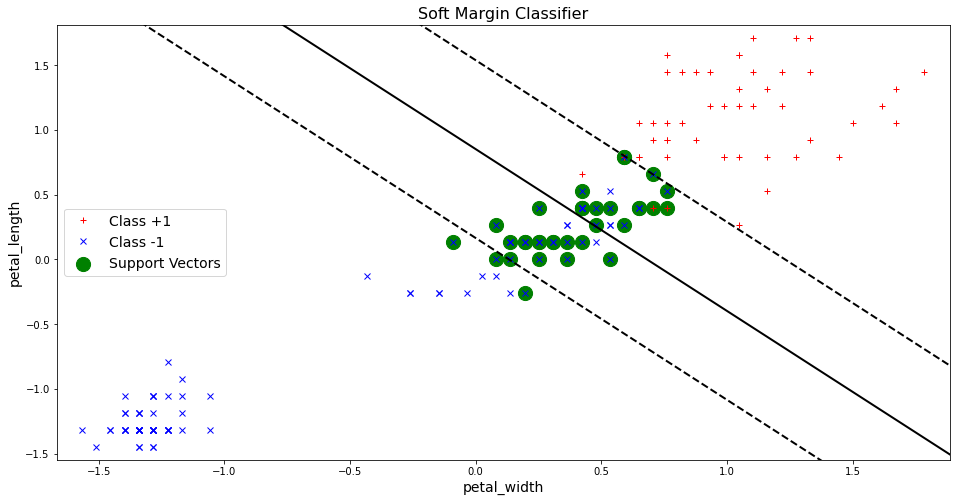

In [ ]:
def decision_boundary_support_vectors(svm_clf, X):
  xmin, xmax = X.min() - 1 , X.max() + 1
    
  w = svm_clf.coef_
  b = svm_clf.intercept_
  #print(w)
  #print(b)
  #print(svm_clf.support_vectors_)
  # At the decision boundary, w1*x1 + w2*x2 + b = 0
  # => x2 = -(b + w1* x1)/w1
  x1 = np.linspace(xmin, xmax, 2)
  
  decision_boundary = -(b + w[0] * x1) / w[1]
  shifting_factor_for_margin = 1/w[1]
  upper_margin = decision_boundary + shifting_factor_for_margin
  lower_margin = decision_boundary - shifting_factor_for_margin
  svs = svm_clf.support_vectors_
  plt.scatter(svs[:, 0], svs[:, 1], s=200, facecolors='g', label="Support Vectors")
  plt.plot(x1, decision_boundary, "k-", linewidth=2)
  plt.plot(x1, upper_margin, "k--", linewidth=2)
  plt.plot(x1, lower_margin, "k--", linewidth=2)


plt.figure(figsize=(16,8))
positive_class = X[y.ravel() == 1]
negative_class = X[y.ravel() == -1]
plt.plot(positive_class[:, 0], positive_class[:, 1], "r+", label="Class +1")
plt.plot(negative_class[:, 0], negative_class[:, 1], "bx", label="Class -1")


decision_boundary_support_vectors(svm_clf_2, X)



plt.xlabel("petal_width", fontsize=14)
plt.ylabel("petal_length", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("Soft Margin Classifier", fontsize=16)
plt.axis([np.amin(X[:, 0])-0.1, np.amax(X[:, 0])+0.1, 
          np.amin(X[:, 1])-0.1, np.amax(X[:, 1])+0.1])
#plt.xticks(())
#plt.yticks(())
#plt.
plt.show()

# Part B: Principle Component Analysis

## 9. Read the image

Dimension of X: (799, 1200)


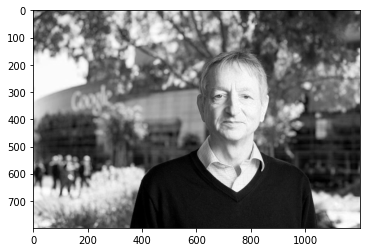

In [ ]:
X = plt.imread("Hinton.jpg")[:,:,0]
plt.gray()
plt.imshow(X)
print("Dimension of X: " + str(X.shape))

## 10. Eigendecomposition

In [ ]:
def eigendecomposition(X):
  X_mean = np.mean(X, axis=0)
  X_centered = X - X_mean
  cov_X = np.cov(X_centered.T)
  eigenvalues, eigenvectors = eig(cov_X)
  return X_centered, eigenvalues, eigenvectors

## 11. Find top k eigenvectors

In [ ]:
def find_top_k_eigenvectors(k, eigenvalues, eigenvectors):
  top_eigenvectors = np.zeros((k, len(eigenvalues)))
  eigenvectors = eigenvectors.T
  # temp = []
  for i in range(k):
    max_eigenvalue_index = np.argmax(eigenvalues)
    # temp.append(max_eigenvalue_index)
    top_eigenvectors[i] = eigenvectors[max_eigenvalue_index]
    eigenvectors = np.delete(eigenvectors, max_eigenvalue_index, 0)
    eigenvalues = np.delete(eigenvalues, max_eigenvalue_index, 0)
  # print(temp)
  return top_eigenvectors.T

## 12. Project mean centered data onto top eigenvectors

In [ ]:
def project_mean_centered_data(X_centered, top_k_eigenvectors):
  return X_centered.dot(top_k_eigenvectors)

## 13. Reconstruct data matrix

In [ ]:
def reconstruct_data_matrix(X_projected, top_k_eigenvectors):
  return X_projected.dot(top_k_eigenvectors.T)

## 14. Comupte Reconstruction Error

In [ ]:
def compute_reconstruction_error(X_centered, X_reconstructed):
  return mean_squared_error(X_centered, X_reconstructed)

## 15. Perform PCA on varying k

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


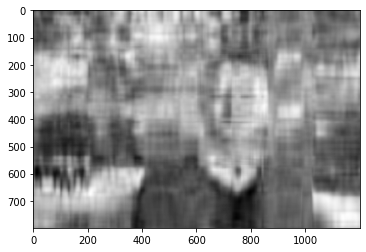

Reconstruction error for k= 10 :  469.80185123172123 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


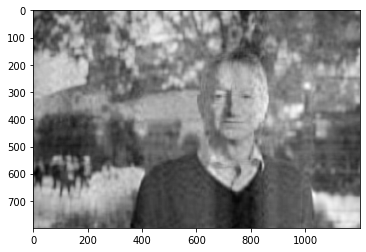

Reconstruction error for k= 30 :  103.60503214223388 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


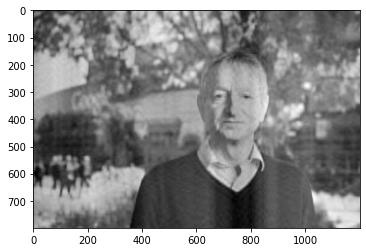

Reconstruction error for k= 50 :  39.08918084106296 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


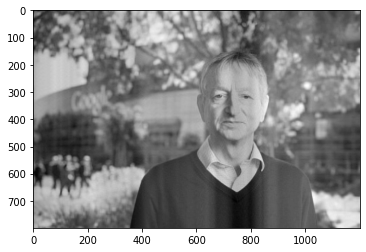

Reconstruction error for k= 100 :  10.181165118643886 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


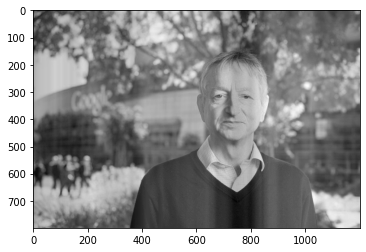

Reconstruction error for k= 500 :  0.05468781621473165 



In [ ]:
K = [10, 30, 50, 100, 500]
for k in K:
  X_centered, eigenvalues, eigenvectors = eigendecomposition(X)
  top_k_eigenvectors = find_top_k_eigenvectors(k, eigenvalues, eigenvectors)
  X_projected = project_mean_centered_data(X_centered, top_k_eigenvectors)
  X_reconstructed = reconstruct_data_matrix(X_projected, top_k_eigenvectors)
  plt.imshow(X_reconstructed)
  plt.show()
  reconstruction_error = compute_reconstruction_error(X_centered, X_reconstructed)
  print("Reconstruction error for k=", k, ": ", reconstruction_error, "\n")